# Artificial Neural Networks and Deep Learning



---



## Homework 2: 

## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras import backend as K
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ConvNeXtBase
seed = 42
np.random.seed(42)
tf.random.set_seed(42)

# custom module for augmentation
import sys
sys.path.append('/kaggle/input/aug-pipeline/') # Version 1 (without tensors)
from AugmentationHelper import apply_total_transform, apply_intensity_transform, apply_geometric_transform

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:51: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


## ⏳ Load the Data

In [2]:
# file_path = "/kaggle/input/mars-data/mars_for_students.npz"
file_path = "/kaggle/input/mars-data/mars_for_students_cleaned.npz"

data = np.load(file_path)

training_set = data["training_set"]
X_test_submission = data["test_set"]

images = training_set[:, 0]
labels = training_set[:, 1]

images = images.astype(np.uint8)
labels = labels.astype(np.uint8)

print(f"Training set shape: {training_set.shape}")
print(f"Test set shape: {X_test_submission.shape}")

print(f"X shape: {images.shape}")
print(f"y shape: {labels.shape}")

Training set shape: (2102, 2, 64, 128)
Test set shape: (10022, 64, 128)
X shape: (2102, 64, 128)
y shape: (2102, 64, 128)


2102 samples to train and 10022 samples to test... Lot of augmentation is needed

### Some exploration (ignore)

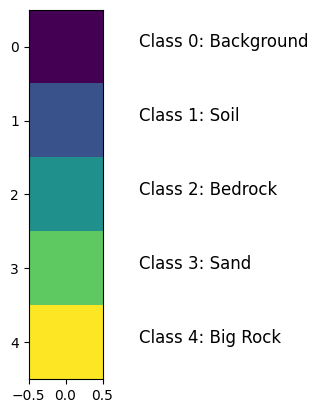

In [3]:
# Labels dictionary
labels_map = {0: "Background", 1: "Soil", 2: "Bedrock", 3: "Sand", 4: "Big Rock"}

plt.imshow([[i] for i in range(5)])
for i in range(5):
    plt.text(1, i, f"Class {i}: {labels_map[i]}", fontsize=12)

plt.show()

In [4]:
n_samples = images.shape[0]
n_samples

2102

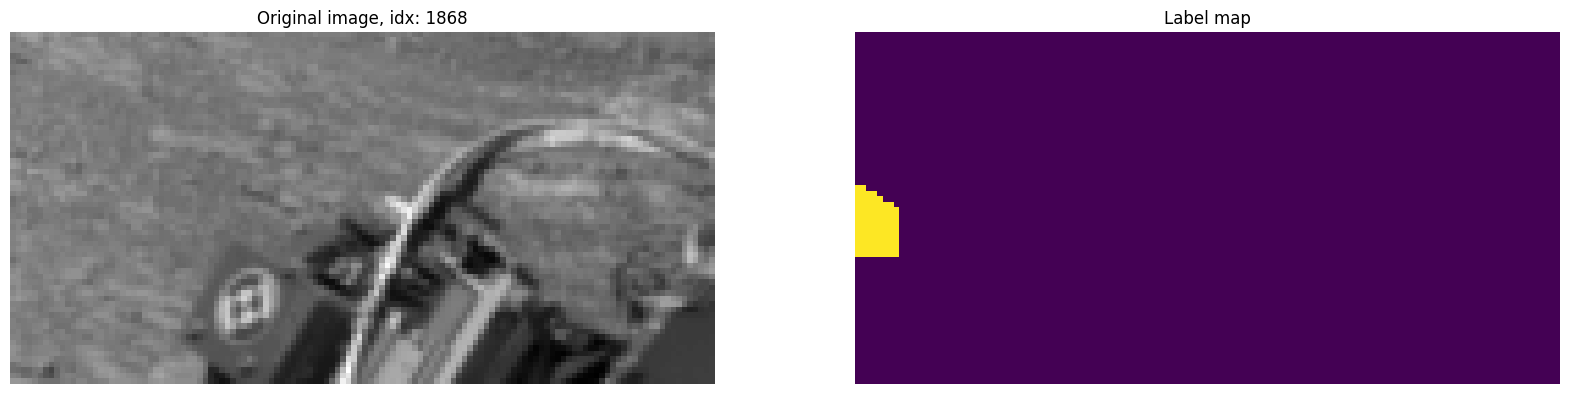

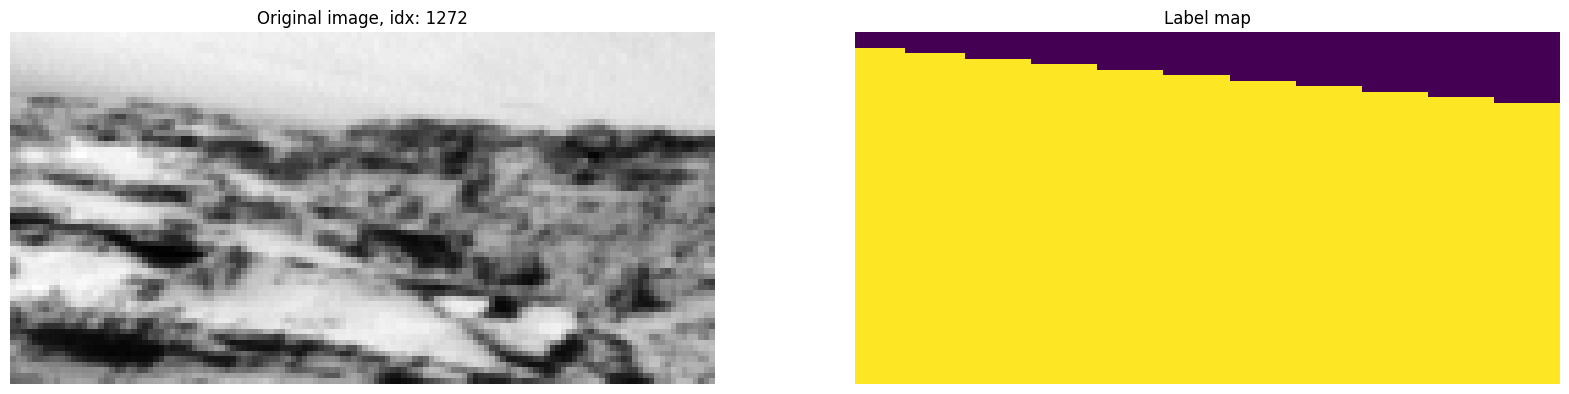

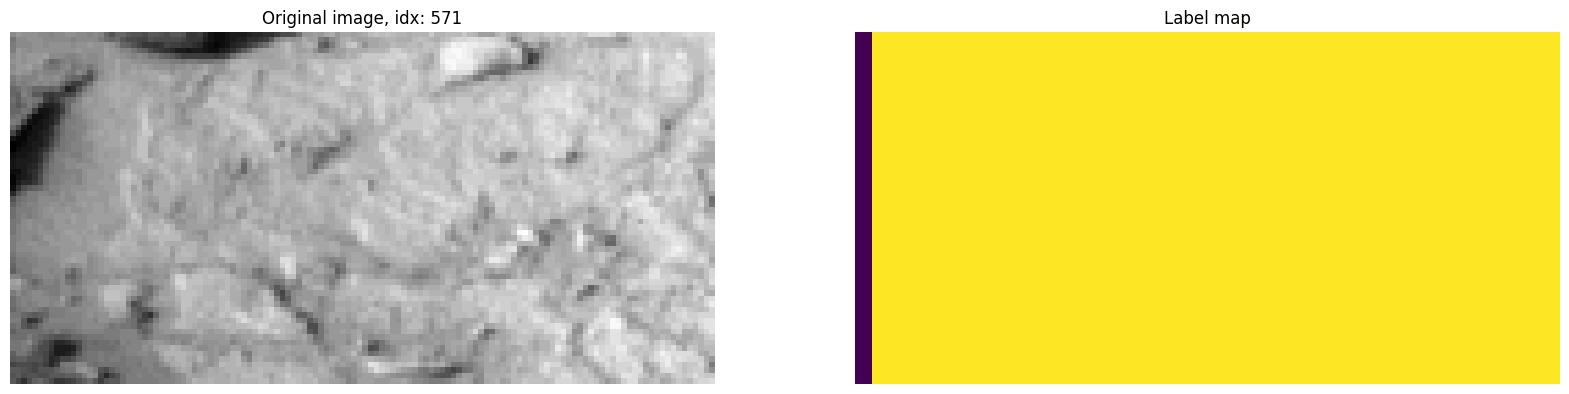

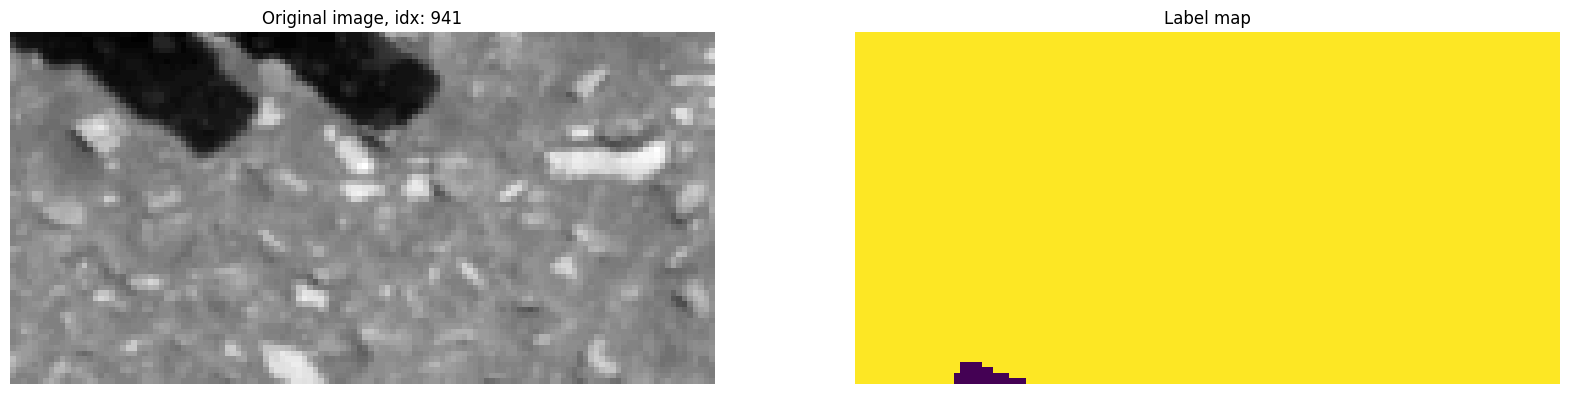

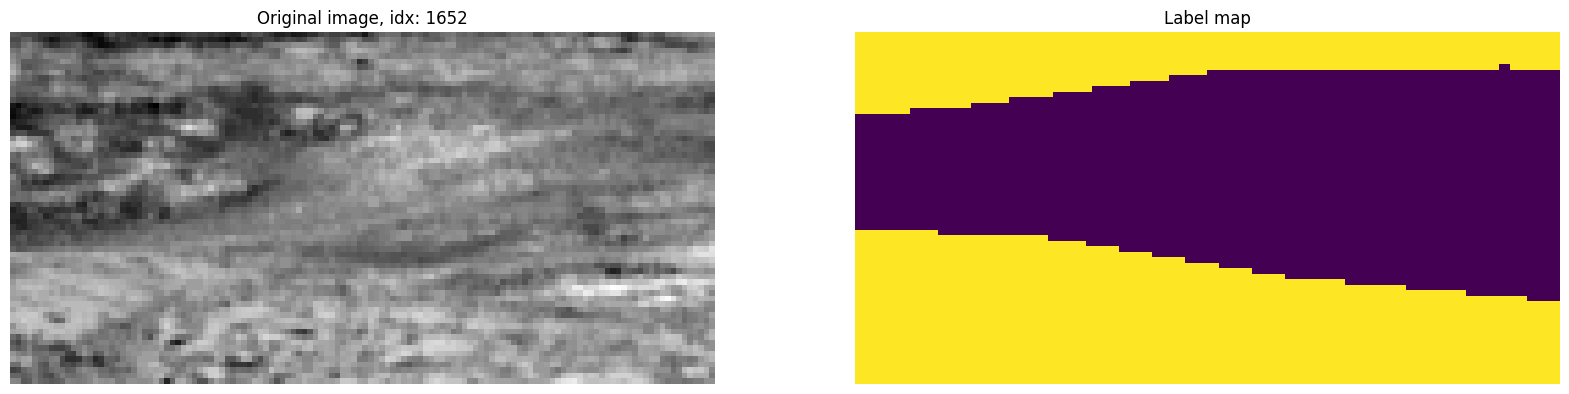

In [5]:
rand_samples = np.random.choice(n_samples, size=5, replace=False)
for sample in rand_samples:
    plt.figure(figsize=(20, 5))
    plt.subplot(121), plt.imshow(images[sample], cmap="gray"), plt.title(
        f"Original image, idx: {sample}"
    ), plt.axis("off")
    plt.subplot(122), plt.imshow(labels[sample]), plt.title("Label map"), plt.axis(
        "off"
    )
    plt.show()

## Data splitting

In [6]:
# 5% of input data to validation sets
validation_ratio = 0.05 / 0.9

train_img, val_img, train_lbl, val_lbl = train_test_split(
    images, labels, test_size=validation_ratio, random_state=seed
)

print(f"Number of images")
print(f"Train: \t\t{len(train_img)}")
print(f"Validation: \t{len(val_img)}")

Number of images
Train: 		1985
Validation: 	117


In [7]:
# Set number of classes
NUM_CLASSES = 5

# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

## Preprocessing

In [8]:
print("Range of values before rescaling ")
print("Images:", images.min(), images.max())
print("Labels:", labels.min(), labels.max())

Range of values before rescaling 
Images: 2 254
Labels: 0 4


before rescaling let's do augmentation, since albumentation takes range from 0-255

In [9]:
train_img_i, train_lbl_i = apply_intensity_transform(train_img, train_lbl)
train_img_g, train_lbl_g = apply_geometric_transform(train_img, train_lbl)
train_img_t, train_lbl_t = apply_total_transform(train_img, train_lbl)

train_img = np.concatenate((train_img, train_img_i, train_img_g, train_img_t), axis=0)
train_lbl = np.concatenate((train_lbl, train_lbl_i, train_lbl_g, train_lbl_t), axis=0)

In [11]:
"Size of train dataset after augmentation", len(train_img)

('Size of train dataset after augmentation', 7940)

Check if classes are balanced after augmentation

In [12]:
# Step 1: Flatten the masks
flattened_masks = train_lbl.flatten()  # Shape: (N * H * W,)

# Step 2: Count pixels for each class
class_pixel_counts = np.bincount(
    flattened_masks, minlength=5
)  # minlength = total classes

# Step 3: Calculate class proportions
total_pixels = flattened_masks.size
class_proportions = class_pixel_counts / total_pixels

# Display results
print("Class Pixel Counts:", class_pixel_counts)
print("Class Proportions:", class_proportions)

Class Pixel Counts: [13329614 24682391 14924737 12042475    65263]
Class Proportions: [0.20493075 0.37946942 0.22945432 0.18514215 0.00100336]


most undersampled class is class #4, alpha is showing the "importance" that we need to assing to each class

In [13]:
# Calculate the alpha for focal loss
alpha = 1.0 / (class_proportions + 1e-8)  # Add epsilon to avoid division by zero
alpha /= np.sum(alpha)  # Normalize so that the sum of alpha values equals 1

# Display results
print("Alpha Values:", alpha)

Alpha Values: [0.00481272 0.00259909 0.00429835 0.00532712 0.98296272]


In [14]:
# TODO: probably we can assign to class 0 a weight of 0
class_weight_dict = {i: weight for i, weight in enumerate(alpha)}

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.004812722413098377, 1: 0.002599089103466361, 2: 0.004298349270095764, 3: 0.005327121851709178, 4: 0.9829627173616303}


In [15]:
def load_single_image(image, label, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.cast(image, tf.float32)
    image = image[..., np.newaxis] / 255.0
    image = tf.image.grayscale_to_rgb(image)

    # Read and preprocess the label
    label = tf.cast(label, tf.int32)
    label = label[..., np.newaxis]
    return image, label

In [16]:
category_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


def apply_category_mapping(label):
    """Apply category mapping to labels."""

    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), default_value=0
    )

    return table.lookup(label)  # @tf.function

In [17]:
# Note: If we are not able to integrate the module, let's add it like this
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(image), lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(label), lambda: label
    )
    return image, label

In [18]:
def make_dataset(
    image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None
):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(load_single_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        # Note: If we are not able to integrate the module, let's add it like this
        dataset = dataset.map(
            lambda x, y: random_flip(x, y), num_parallel_calls=tf.data.AUTOTUNE
        )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)), num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [19]:
# Create the datasets
print("Creating datasets...")

train_dataset = make_dataset(
    train_img, train_lbl, batch_size=BATCH_SIZE, shuffle=True, augment=False, seed=seed
)

val_dataset = make_dataset(val_img, val_lbl, batch_size=BATCH_SIZE, shuffle=False)

print("Datasets created!")

Creating datasets...
Datasets created!


In [20]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 64, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 128, 1), dtype=tf.int32, name=None))>

In [21]:
# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"Input shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Input shape: (64, 128, 3)
Images shape: (64, 64, 128, 3)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


In [23]:
def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j * 2 + 1)
            plt.imshow(images[j])
            plt.title(f"Image {j+1}")
            plt.axis("off")

            # Plot colored label
            plt.subplot(num_samples, 2, j * 2 + 2)
            plt.imshow(labels_np[j])
            plt.title(f"Label {j+1}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()


Visualizing examples from the training set:


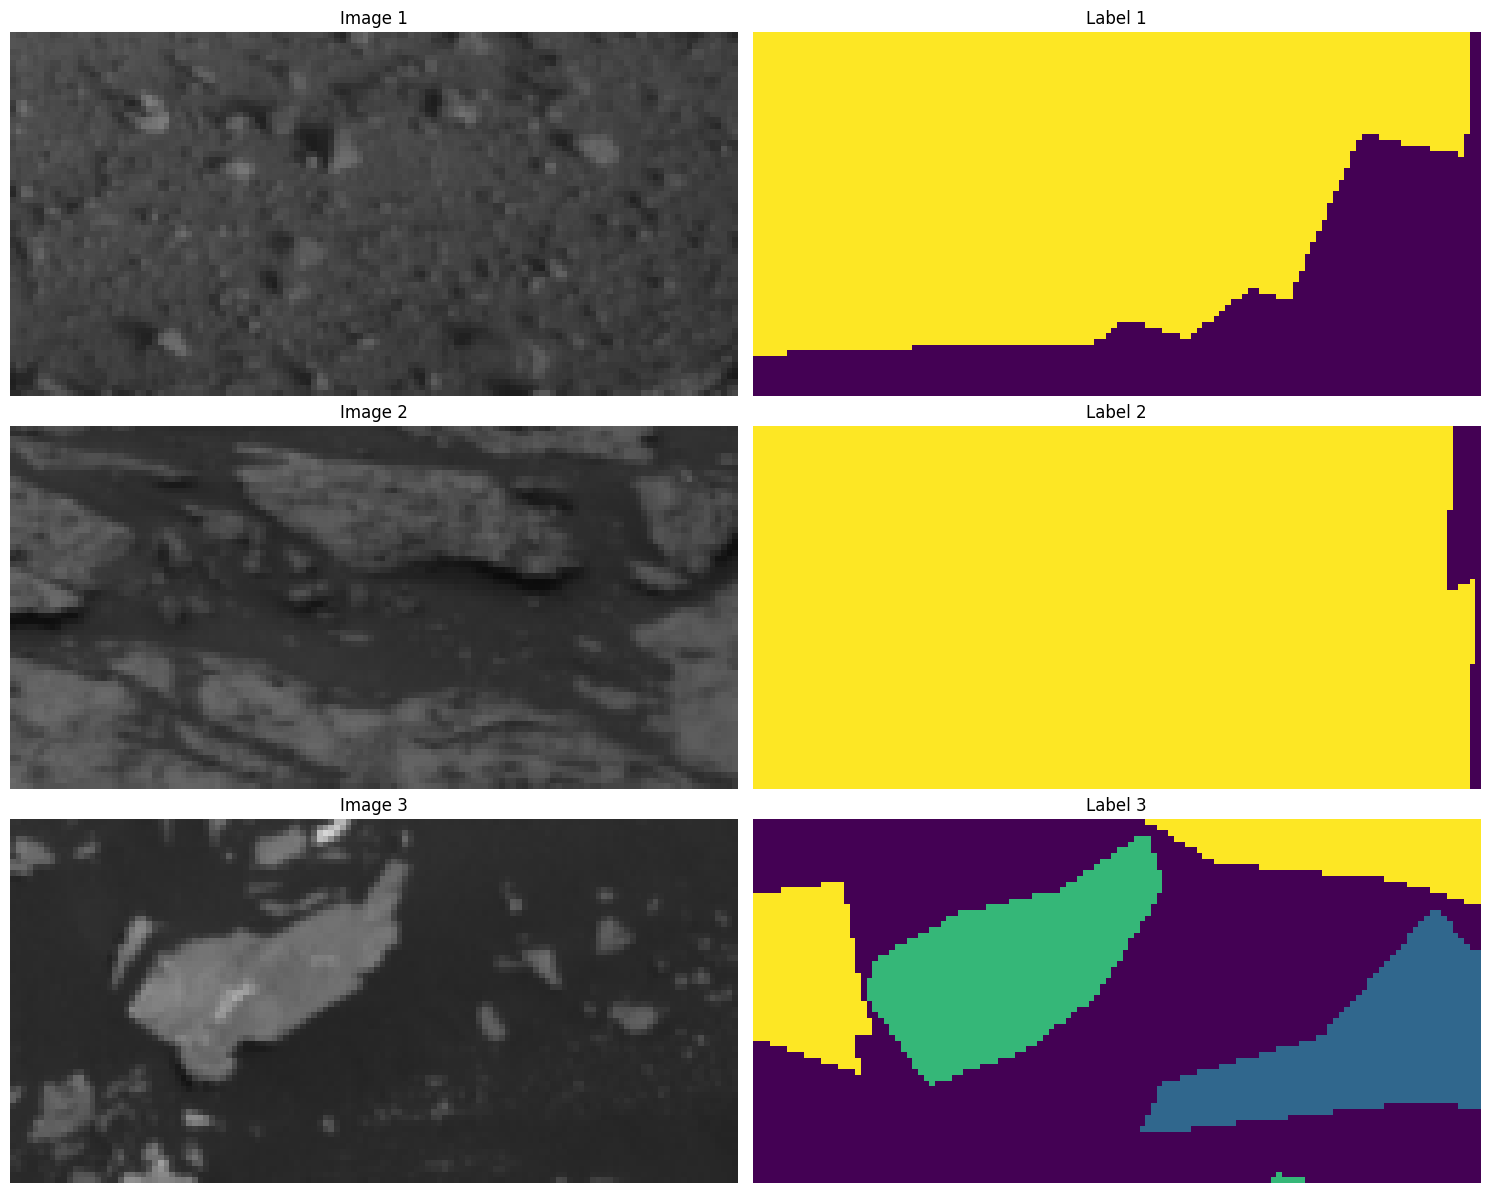

In [24]:
# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

## Build the Models

### Attention U-Net

In [25]:
def attention_block(x, g, inter_channel):
    # Generate query, key, and value tensors
    theta_x = tfkl.Conv2D(inter_channel, (1, 1), padding="same")(x)  # Query
    phi_g = tfkl.Conv2D(inter_channel, (1, 1), padding="same")(g)  # Key
    attn = tfkl.Activation("sigmoid")(tfkl.Add()([theta_x, phi_g]))  # Attention Map
    attn = tfkl.Conv2D(1, (1, 1), padding="same")(attn)  # Value

    # Multiply attention map with the input feature map
    return tfkl.Multiply()([x, attn])


def attention_u_net(
    input_shape=input_shape,
    depth=4,
    d_conv_count=3,
    b_conv_count=3,
    u_conv_count=3,
    start_filter=32,
    skip_connections=True,
    dropout=0.2,
    NUM_CLASSES=5,
):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name="input_layer")

    x = inputs
    skipped = []

    # Downsampling
    for i in range(depth):

        for j in range(d_conv_count):
            x = tfkl.Conv2D(
                filters=start_filter, kernel_size=(3, 3), strides=(1, 1), padding="same"
            )(x)
            x = tfkl.BatchNormalization()(x)
            x = tfkl.ReLU()(x)

        if skip_connections:
            # Save the layer for skip connections
            skipped.append(x)

        x = tfkl.MaxPooling2D(pool_size=(2, 2))(x)
        x = tfkl.Dropout(dropout)(x)

        start_filter = start_filter * 2

    # Bottleneck
    for j in range(b_conv_count):
        x = tfkl.Conv2D(
            filters=start_filter, kernel_size=(3, 3), strides=(1, 1), padding="same"
        )(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)

    start_filter = start_filter // 2

    # Upsampling
    for i in range(depth):

        x = tfkl.UpSampling2D(2, interpolation="bilinear")(x)

        if skip_connections:
            # Apply attention mechanism to the skip connections
            x = attention_block(x, skipped[depth - i - 1], start_filter)

        x = tfkl.Dropout(dropout)(x)

        for j in range(u_conv_count):
            x = tfkl.Conv2D(
                filters=start_filter, kernel_size=(3, 3), strides=(1, 1), padding="same"
            )(x)
            x = tfkl.BatchNormalization()(x)
            x = tfkl.ReLU()(x)

        start_filter = start_filter // 2

    # Output Layer
    outputs = tfkl.Conv2D(
        filters=NUM_CLASSES,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding="same",
        activation="softmax",
        name="output_layer",
    )(x)

    model = Model(inputs, outputs, name="Attention_UNet")
    return model

### Regular U-Net

In [26]:
def u_net(
    input_shape=input_shape,
    depth=4,
    d_conv_count=3,
    b_conv_count=3,
    u_conv_count=3,
    start_filter=32,
    skip_connections=True,
    dropout=0.2,
):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name="input_layer")

    x = inputs
    skipped = []
    # Downsampling
    for i in range(depth):
        for j in range(d_conv_count):
            x = tfkl.Conv2D(
                filters=start_filter, kernel_size=(3, 3), strides=(1, 1), padding="same"
            )(x)
            x = tfkl.BatchNormalization()(x)
            x = tfkl.ReLU()(x)

        if skip_connections:
            # Save the layer for skip connections
            skipped.append(x)

        x = tfkl.MaxPooling2D(pool_size=(2, 2))(x)
        x = tfkl.Dropout(dropout)(x)

        start_filter = start_filter * 2

    # Bottleneck
    for j in range(b_conv_count):
        x = tfkl.Conv2D(
            filters=start_filter, kernel_size=(3, 3), strides=(1, 1), padding="same"
        )(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)

    start_filter = start_filter // 2

    # Upsampling
    for i in range(depth):
        x = tfkl.UpSampling2D(2, interpolation="bilinear")(x)

        if skip_connections:
            x = tfkl.Concatenate()([x, skipped[depth - i - 1]])

        x = tfkl.Dropout(dropout)(x)

        for j in range(u_conv_count):
            x = tfkl.Conv2D(
                filters=start_filter, kernel_size=(3, 3), strides=(1, 1), padding="same"
            )(x)
            x = tfkl.BatchNormalization()(x)  ## remove?
            x = tfkl.ReLU()(x)
        start_filter = start_filter // 2

    # Output Layer
    outputs = tfkl.Conv2D(
        filters=NUM_CLASSES,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding="same",
        activation="softmax",
        name="output_layer",
    )(x)

    model = tf.keras.Model(inputs, outputs, name="UNet")
    return model

### Dense U-Net

In [27]:
"""
References:
Paper: https://qims.amegroups.org/article/view/43519/html
Code: https://github.com/THUHoloLab/Dense-U-net/blob/master/Dense-U-net/Dense_U_net.py
"""


def dense_unet(
    input_shape=input_shape,
    depth=4,
    d_conv_count=3,
    u_conv_count=3,
    start_filter=32,
    dropout=0.2,
):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name="input_layer")

    next = inputs
    skipped = []

    # Downsampling
    for i in range(depth):
        # Now this is a Dense Block
        for j in range(d_conv_count):

            x = tfkl.Conv2D(
                filters=start_filter,
                kernel_size=(3, 3),
                kernel_initializer="he_normal",
                strides=(1, 1),
                padding="same",
            )(next)
            x = tfkl.BatchNormalization()(x)
            conv_block = tfkl.ReLU()(x)
            next = tfkl.Concatenate()([conv_block, next])

        skipped.append(conv_block)

        x = tfkl.MaxPooling2D(pool_size=(2, 2))(conv_block)
        next = tfkl.Dropout(dropout)(x)

        start_filter = start_filter * 2

    # Bottleneck
    x = tfkl.Conv2D(
        filters=start_filter,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer="he_normal",
        padding="same",
    )(next)
    x = tfkl.BatchNormalization()(x)  ##### not sure
    x = tfkl.ReLU()(x)
    next = tfkl.Dropout(dropout)(x)

    start_filter = start_filter // 2

    # Upsampling
    for i in range(depth):
        x = tfkl.UpSampling2D(2, interpolation="bilinear")(next)
        x = tfkl.Concatenate()([x, skipped.pop()])  ## try without axis
        next = tfkl.Dropout(dropout)(x)

        # Dense Block again
        for j in range(u_conv_count):

            x = tfkl.Conv2D(
                filters=start_filter,
                kernel_size=(3, 3),
                kernel_initializer="he_normal",
                strides=(1, 1),
                padding="same",
            )(next)
            x = tfkl.BatchNormalization()(x)
            conv_block = tfkl.ReLU()(x)
            next = tfkl.Concatenate()([conv_block, next])

        start_filter = start_filter // 2

    # Output Layer
    outputs = tfkl.Conv2D(
        filters=NUM_CLASSES,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding="same",
        activation="sigmoid",
        name="output_layer",
    )(next)

    model = tf.keras.Model(inputs, outputs, name="Dense_UNet")
    return model

### Current in use model

In [28]:
model = attention_u_net()


# Print a detailed summary of the model with expanded nested layers and trainable parameters.

model.summary(expand_nested=True, show_trainable=True)

Model: "Attention_UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │       896 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu (ReLU)      │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu[0][0]    │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_1 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu_1[0][0]  │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_2[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_2 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ re_lu_2[0][0]  │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 32, 64,  │         0 │ max_pooling2d… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 32, 64,  │    18,496 │ dropout[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_3[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_3 (ReLU)    │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 32, 64,  │    36,928 │ re_lu_3[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_4[0][0] │   Y 

 Total params: 11,271,145 (43.00 MB)

 Trainable params: 11,262,313 (42.96 MB)

 Non-trainable params: 8,832 (34.50 KB)

## Metrics

In [29]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):

    def __init__(
        self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None
    ):

        super(MeanIntersectionOverUnion, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )

        if labels_to_exclude is None:

            labels_to_exclude = [0]  # Default to excluding label 0

        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):

        # Convert predictions to class labels

        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors

        y_true = tf.reshape(y_true, [-1])

        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels

        for label in self.labels_to_exclude:

            mask = tf.not_equal(y_true, label)

            y_true = tf.boolean_mask(y_true, mask)

            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state

        return super().update_state(y_true, y_pred, sample_weight)

In [30]:
# https://stackoverflow.com/questions/65125670/implementing-multiclass-dice-loss-function
def dice_loss(y_true, y_pred, smooth=1e-7):
    """
    Dice coefficient for X categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    """
    y_true_f = K.flatten(
        K.one_hot(K.cast(y_true, "int32"), num_classes=NUM_CLASSES)[..., 1:]
    )
    y_pred_f = K.flatten(y_pred[..., 1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2.0 * intersect / (denom + smooth)))


def dice_loss_multiclass(y_true, y_pred):
    """
    Dice loss to minimize. Pass to model as loss during compile statement
    """
    return 1 - dice_loss(y_true, y_pred)


def combined_multiclass_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    dice = dice_loss_multiclass(y_true, y_pred)
    categorical_ce = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    return alpha * dice + beta * categorical_ce

In [31]:
# Compile the model
print("Compiling model...")

model.compile(
    loss=dice_loss_multiclass, #tf.keras.losses.Dice, #tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=[
        "accuracy",
        MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0]),
    ],
)

print("Model compiled!")

Compiling model...
Model compiled!


## 🛠️ Train the Model

In [32]:
# Setup callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", mode="max", patience=PATIENCE, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, mode="auto", min_lr=1e-5
)

In [33]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    class_weight=class_weight_dict,  # to balance classes
).history

Epoch 1/1000


I0000 00:00:1733681429.105477     936 service.cc:145] XLA service 0x7e4680011f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733681429.105539     936 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:54:42 56s/step - accuracy: 0.2010 - loss: 0.0036 - mean_iou: 0.0581

I0000 00:00:1733681466.726443     936 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 115s 480ms/step - accuracy: 0.3652 - loss: 0.0033 - mean_iou: 0.1516 - val_accuracy: 0.2793 - val_loss: 0.7045 - val_mean_iou: 0.0892 - learning_rate: 0.0010
Epoch 2/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.4283 - loss: 0.0026 - mean_iou: 0.1914 - val_accuracy: 0.3482 - val_loss: 0.6231 - val_mean_iou: 0.1604 - learning_rate: 0.0010
Epoch 3/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.4612 - loss: 0.0024 - mean_iou: 0.2697 - val_accuracy: 0.3166 - val_loss: 0.6458 - val_mean_iou: 0.1284 - learning_rate: 0.0010
Epoch 4/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.4799 - loss: 0.0023 - mean_iou: 0.3058 - val_accuracy: 0.3659 - val_loss: 0.5914 - val_mean_iou: 0.2089 - learning_rate: 0.0010
Epoch 5/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.5095 - loss: 0.0021 - mean_iou: 0.3330 - val_accuracy: 0.3089 - val_loss: 0.6551 - val_mean_iou: 0.1642 - learning_rate: 0.0010
Epoch 6/1000
125/

In [34]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history["val_mean_iou"]) * 100, 2)
print(f"Final validation Mean Intersection Over Union: {final_val_meanIoU}%")

Final validation Mean Intersection Over Union: 38.93%


In [35]:
# Save the trained model to a file with the accuracy included in the filename

model_filename = "model.keras"
model.save(model_filename)

# Delete the model to free up resources
del model

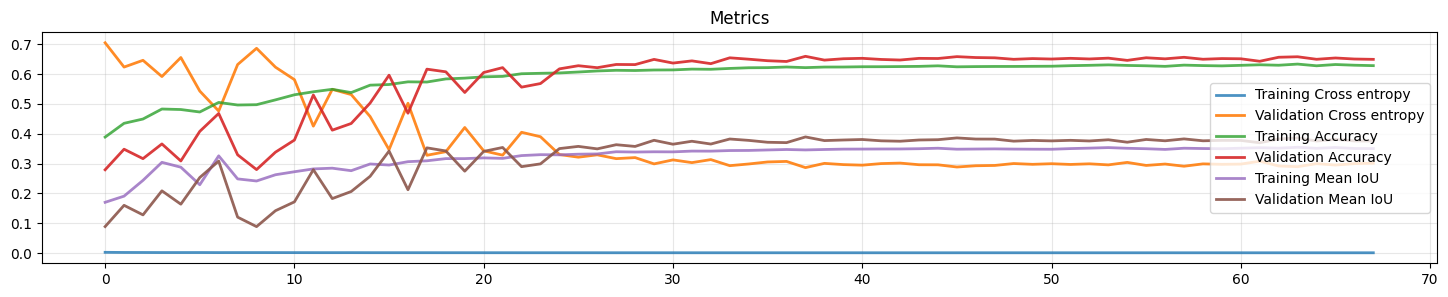

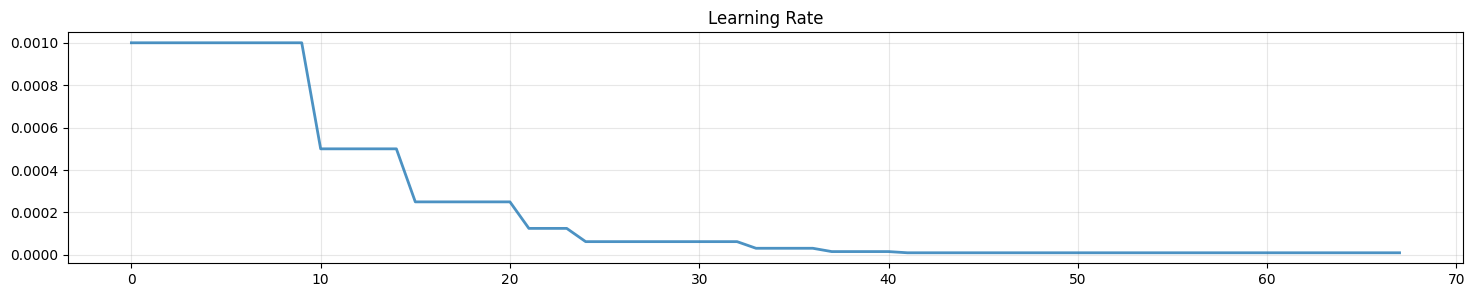

In [37]:
#Plot Metrics

plt.figure(figsize=(18, 3))
# Plot and display training and validation loss
plt.plot(history["loss"], label="Training Cross entropy", alpha=0.8, linewidth=2)
plt.plot(history["val_loss"], label="Validation Cross entropy", alpha=0.9, linewidth=2)

# Plot and display training and validation accuracy
plt.plot(history['accuracy'], label='Training Accuracy', alpha=0.8, linewidth=2)
plt.plot(history['val_accuracy'], label='Validation Accuracy', alpha=0.9, linewidth=2)

# Plot and display training and validation mean IoU
plt.plot(history["mean_iou"], label="Training Mean IoU", alpha=0.8, linewidth=2)
plt.plot(history["val_mean_iou"], label="Validation Mean IoU", alpha=0.9, linewidth=2)

plt.title("Metrics")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot Learning rate
plt.figure(figsize=(18, 3))
plt.plot(history["learning_rate"], label="Learning rate", alpha=0.8, linewidth=2)
plt.title("Learning Rate")
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission



In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [38]:
print(f"Test X shape: {X_test_submission.shape}")

X_test_submission = X_test_submission[..., np.newaxis] / 255.0

X_test_submission = tf.cast(X_test_submission, tf.float32)

X_test_submission = tf.image.grayscale_to_rgb(X_test_submission)

Test X shape: (10022, 64, 128)


In [39]:
# Load UNet model without compiling

model = tfk.models.load_model("/kaggle/working/model.keras", compile=False)


# Compile the model with specified loss, optimizer, and metrics

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), #shouldn't this be the same one as used before (dice)
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=[
        "accuracy",
        MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0]),
    ],
)


# Print a detailed summary of the model with expanded nested layers and trainable parameters.

model.summary(expand_nested=True, show_trainable=True)

Model: "Attention_UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │       896 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu (ReLU)      │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu[0][0]    │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_1 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu_1[0][0]  │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_2[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_2 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ re_lu_2[0][0]  │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 32, 64,  │         0 │ max_pooling2d… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 32, 64,  │    18,496 │ dropout[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_3[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_3 (ReLU)    │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 32, 64,  │    36,928 │ re_lu_3[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_4[0][0] │   Y 

 Total params: 11,271,145 (43.00 MB)

 Trainable params: 11,262,313 (42.96 MB)

 Non-trainable params: 8,832 (34.50 KB)

In [40]:
preds = model.predict(X_test_submission)

preds = np.argmax(preds, axis=-1)

print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step
Predictions shape: (10022, 64, 128)


In [41]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""

    n_samples = len(y)

    y_flat = y.reshape(n_samples, -1)

    df = pd.DataFrame(y_flat)

    df["id"] = np.arange(n_samples)

    cols = ["id"] + [col for col in df.columns if col != "id"]

    return df[cols]

In [42]:
# Create and download the csv submission file

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.csv'

submission_df = y_to_df(preds)

submission_df.to_csv(filename, index=False)

filename

'submission_241208_183724.csv'